<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/ECG_MultiLabel_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Multi-Label Model Training (Self-Contained)
Fully independent notebook: loads preprocessed data, trains multi-label model, saves results

In [ ]:
!pip install tensorflow scikit-learn matplotlib seaborn huggingface-hub h5py -q

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    hamming_loss, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix,
    accuracy_score, jaccard_score
)

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

## Environment & Data Loading

In [9]:
# Download preprocessed data from Hugging Face
from huggingface_hub import snapshot_download
import h5py

print("Downloading preprocessed data from Hugging Face...")
local_dir = snapshot_download(
    repo_id="kiril-buga/ECG-database",
    repo_type="dataset",
    local_dir="./ECG-database/",
    allow_patterns=["multilabel_v2/*"]  # Only download preprocessed data (~1.5-2 GB)
)

DATA_DIR = os.path.join(local_dir, "multilabel_v2")
RESULTS_DIR = "./results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✓ Downloaded to: {DATA_DIR}")
print(f"✓ Results will be saved to: {RESULTS_DIR}")

# ============================================================================
# Load dataset structure from HDF5 and create streaming data generator
h5_path = os.path.join(DATA_DIR, "ecg_data.h5")

print(f"\nOpening HDF5 file: {h5_path}")
with h5py.File(h5_path, 'r') as h5f:
    n_samples = h5f['X'].shape[0]
    input_shape = h5f['X'].shape[1:]
    DISEASE_CLASSES = list(h5f.attrs['disease_classes'])
    data_format = h5f.attrs.get('data_format', 'unknown')

print(f"✓ Dataset info:")
print(f"  Total windows: {n_samples}")
print(f"  Input shape: {input_shape}")
print(f"  Data format: {data_format}")
print(f"  Classes: {DISEASE_CLASSES}")

# Create train/val/test split indices (without loading data)
all_idx = np.arange(n_samples)
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

print(f"\nTrain: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# Create tf.data.Dataset objects
def create_dataset(h5_path, indices, batch_size=32, is_training=True):
    """Create streaming dataset from HDF5.

    NOTE: HDF5 requires indices in increasing order for fancy indexing.
    We sort indices before access and unsort after to maintain shuffling.
    """
    def gen():
        with h5py.File(h5_path, 'r') as h5f:
            X_dset = h5f['X']
            y_dset = h5f['y']

            # Shuffle for training, don't shuffle for val/test
            idx = np.random.permutation(indices) if is_training else indices

            for i in range(0, len(idx), batch_size):
                batch_idx = idx[i:i+batch_size]

                # HDF5 requires sorted indices for fancy indexing
                # So we sort, access, then unsort to maintain shuffle
                batch_idx_sorted = np.sort(batch_idx)
                X_batch = X_dset[batch_idx_sorted]
                y_batch = y_dset[batch_idx_sorted]

                # Create unsort permutation to restore original shuffle order
                unsort_idx = np.argsort(np.argsort(batch_idx))
                X_batch = X_batch[unsort_idx]
                y_batch = y_batch[unsort_idx]

                # Convert float16 to float32 if needed
                if X_batch.dtype == np.float16:
                    X_batch = X_batch.astype(np.float32)

                yield X_batch, y_batch

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(DISEASE_CLASSES)), dtype=tf.int32)
        )
    )

    return dataset.prefetch(tf.data.AUTOTUNE)

# Create datasets
print("\nCreating streaming datasets...")
BATCH_SIZE = 32
train_dataset = create_dataset(h5_path, train_idx, batch_size=BATCH_SIZE, is_training=True)
val_dataset = create_dataset(h5_path, val_idx, batch_size=BATCH_SIZE, is_training=False)
test_dataset = create_dataset(h5_path, test_idx, batch_size=BATCH_SIZE, is_training=False)

print(f"✓ Datasets created (batch_size={BATCH_SIZE})")

# Verify dataset contents
print("\nVerifying datasets...")
for batch_X, batch_y in train_dataset.take(1):
    print(f"  Sample batch - X shape: {batch_X.shape}, y shape: {batch_y.shape}")
    for i, cls in enumerate(DISEASE_CLASSES):
        count = int(tf.reduce_sum(batch_y[:, i]).numpy())
        print(f"    {cls}: {count} in batch")
    print("✓ Dataset verification successful!")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Downloaded to: /content/ECG-database/multilabel_v2
✓ Results will be saved to: ./results/

Opening HDF5 file: /content/ECG-database/multilabel_v2/ecg_data.h5
✓ Dataset info:
  Total windows: 59944
  Input shape: (5000, 12)
  Data format: unknown
  Classes: ['Myocarditis', 'Cardiomyopathy', 'Kawasaki', 'CHD', 'Healthy']

Train: 35966, Val: 11989, Test: 11989

Creating streaming datasets...
✓ Datasets created (batch_size=32)

Verifying datasets...
  Sample batch - X shape: (32, 5000, 12), y shape: (32, 5)
    Myocarditis: 1 in batch
    Cardiomyopathy: 0 in batch
    Kawasaki: 0 in batch
    CHD: 1 in batch
    Healthy: 30 in batch
✓ Dataset verification successful!


## Build & Train Model

In [11]:
# Build multi-label 1D CNN model
def build_model(input_shape, num_classes):
    """Build 1D CNN for multi-label classification."""
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 3, padding='same', activation='relu'),
        layers.Conv1D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.Conv1D(128, 3, padding='same', activation='relu'),
        layers.Conv1D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.Conv1D(256, 3, padding='same', activation='relu'),
        layers.Conv1D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='sigmoid')  # Multi-label: sigmoid
    ])

print("Building model...")
model = build_model(input_shape, len(DISEASE_CLASSES))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',  # Multi-label loss
    metrics=['binary_accuracy']
)

print("✓ Model built")
model.summary()

Building model...
✓ Model built


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5000, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2500, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1250, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1250, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 625, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 625, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 312, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,589 (1.88 MB)

 Trainable params: 491,589 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(RESULTS_DIR, f"model_{timestamp}.keras")

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(model_path, monitor='val_binary_accuracy', save_best_only=True)
]

print("Training with streaming data...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)
print(f"✓ Model saved: {model_path}")

Training with streaming data...
Epoch 1/3
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 131s 116ms/step - binary_accuracy: 0.9475 - loss: 0.1620 - val_binary_accuracy: 0.9454 - val_loss: 0.1634 - learning_rate: 0.0010
Epoch 2/3
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 120s 107ms/step - binary_accuracy: 0.9468 - loss: 0.1608 - val_binary_accuracy: 0.9475 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 3/3
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 118s 105ms/step - binary_accuracy: 0.9480 - loss: 0.1561 - val_binary_accuracy: 0.9474 - val_loss: 0.1571 - learning_rate: 0.0010
✓ Model saved: ./results/model_20251122_223730.keras


In [ ]:
# Evaluate on test dataset with comprehensive metrics
print("Evaluating on test set...")
y_test_list = []
y_pred_list = []
y_probs_list = []

for X_batch, y_batch in test_dataset:
    y_test_list.append(y_batch.numpy())
    y_probs = model.predict(X_batch, verbose=0)
    y_probs_list.append(y_probs)
    y_pred = (y_probs >= 0.5).astype(int)
    y_pred_list.append(y_pred)

# Concatenate all batches
y_test = np.concatenate(y_test_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)
y_pred_probs = np.concatenate(y_probs_list, axis=0)

print(f"\n✓ Test set size: {len(y_test)} samples")

# ============================================================================
# COMPREHENSIVE EVALUATION METRICS
# ============================================================================

print("\n" + "="*80)
print("MULTI-LABEL CLASSIFICATION METRICS")
print("="*80)

# Global Metrics
hamming = hamming_loss(y_test, y_pred)
exact_match = np.mean(np.all(y_test == y_pred, axis=1))
subset_accuracy = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
micro_f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"\n1. GLOBAL METRICS:")
print(f"   Hamming Loss (lower is better):      {hamming:.4f}")
print(f"   Exact Match Accuracy (all correct):  {exact_match:.4f}")
print(f"   Subset Accuracy (Jaccard Index):     {subset_accuracy:.4f}")
print(f"   Micro-averaged F1:                   {micro_f1:.4f}")
print(f"   Macro-averaged F1:                   {macro_f1:.4f}")

# Per-class metrics
print(f"\n2. PER-CLASS METRICS:")
print(f"{'Class':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'ROC-AUC':>10} {'Support':>10}")
print("-" * 80)

per_class_results = {}
roc_auc_scores = []

for i, cls in enumerate(DISEASE_CLASSES):
    p = precision_score(y_test[:, i], y_pred[:, i], zero_division=0)
    r = recall_score(y_test[:, i], y_pred[:, i], zero_division=0)
    f = f1_score(y_test[:, i], y_pred[:, i], zero_division=0)
    
    # ROC-AUC (needs probabilities, not binary predictions)
    try:
        roc_auc = roc_auc_score(y_test[:, i], y_pred_probs[:, i])
    except:
        roc_auc = 0.0  # If only one class present
    roc_auc_scores.append(roc_auc)
    
    support = int(y_test[:, i].sum())
    
    per_class_results[cls] = {
        'precision': p, 'recall': r, 'f1': f, 'roc_auc': roc_auc, 'support': support
    }
    
    print(f"{cls:<20} {p:>10.4f} {r:>10.4f} {f:>10.4f} {roc_auc:>10.4f} {support:>10}")

print(f"\nMean ROC-AUC across classes:             {np.mean(roc_auc_scores):.4f}")

# Confusion matrices per class
print(f"\n3. CONFUSION MATRICES (per class, as 2x2 binary classification):")
print()

cm_data = []
for i, cls in enumerate(DISEASE_CLASSES):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else [cm[0, 0], 0, 0, cm[1, 1]]
    
    print(f"{cls}:")
    print(f"  True Negatives:  {int(tn):>6} | False Positives: {int(fp):>6}")
    print(f"  False Negatives: {int(fn):>6} | True Positives:  {int(tp):>6}")
    print()
    
    cm_data.append({'class': cls, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})

# Class distribution
print(f"4. CLASS DISTRIBUTION IN TEST SET:")
print()
for i, cls in enumerate(DISEASE_CLASSES):
    count = int(y_test[:, i].sum())
    pct = 100 * count / len(y_test)
    print(f"   {cls:<20}: {count:>6} ({pct:>5.1f}%)")

print("\n" + "="*80)

In [ ]:
# Evaluation Visualizations
print("Creating evaluation visualizations...")

# 1. ROC Curves per class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

all_fpr = []
all_tpr = []
all_roc_auc = []

for i, cls in enumerate(DISEASE_CLASSES):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_roc_auc.append(roc_auc)
    
    axes[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{cls}')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f'roc_curves_{timestamp}.png'), dpi=150, bbox_inches='tight')
print(f"✓ ROC curves saved")
plt.show()

# 2. Confusion Matrices per class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, cls in enumerate(DISEASE_CLASSES):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = cm[0, 0], 0, 0, cm[1, 1] if cm.shape[0] > 1 else 0
    
    # Normalize for better visualization
    cm_display = np.array([[tn, fp], [fn, tp]])
    
    sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar=False, xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[i].set_title(f'{cls}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f'confusion_matrices_{timestamp}.png'), dpi=150, bbox_inches='tight')
print(f"✓ Confusion matrices saved")
plt.show()

# 3. Metrics summary bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-class F1 scores
f1_scores = [per_class_results[cls]['f1'] for cls in DISEASE_CLASSES]
axes[0].bar(DISEASE_CLASSES, f1_scores, color='steelblue', alpha=0.8)
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Per-Class F1-Score')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Per-class ROC-AUC
roc_aucs = [per_class_results[cls]['roc_auc'] for cls in DISEASE_CLASSES]
axes[1].bar(DISEASE_CLASSES, roc_aucs, color='coral', alpha=0.8)
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Per-Class ROC-AUC Score')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(roc_aucs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f'metrics_summary_{timestamp}.png'), dpi=150, bbox_inches='tight')
print(f"✓ Metrics summary saved")
plt.show()

print("✓ All evaluation visualizations created")

✓ Plot saved


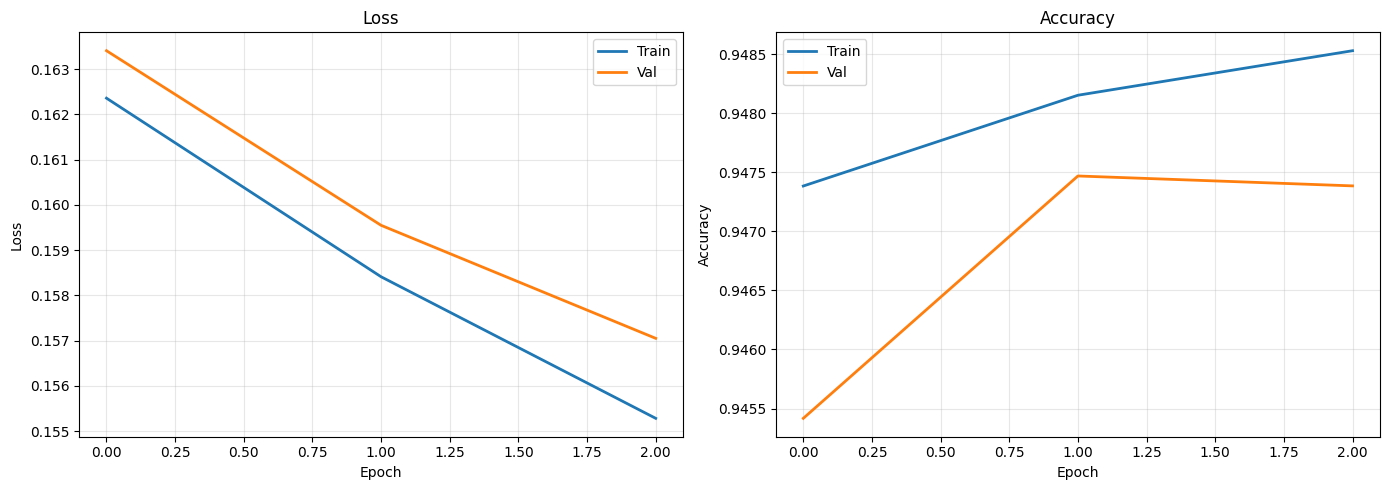

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['binary_accuracy'], label='Train', linewidth=2)
axes[1].plot(history.history['val_binary_accuracy'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f'training_{timestamp}.png'), dpi=150, bbox_inches='tight')
print(f"✓ Plot saved")
plt.show()

## Save Results

In [ ]:
# Save predictions and comprehensive results
np.savez(
    os.path.join(RESULTS_DIR, f"predictions_{timestamp}.npz"),
    y_true=y_test,
    y_pred=y_pred,
    y_probs=y_pred_probs
)

# Save comprehensive results JSON
results = {
    'timestamp': timestamp,
    'disease_classes': DISEASE_CLASSES,
    'epochs_trained': len(history.history['loss']),
    'test_samples': len(y_test),
    
    # Global metrics
    'global_metrics': {
        'hamming_loss': float(hamming),
        'exact_match_accuracy': float(exact_match),
        'subset_accuracy': float(subset_accuracy),
        'micro_f1': float(micro_f1),
        'macro_f1': float(macro_f1),
        'mean_roc_auc': float(np.mean(roc_auc_scores))
    },
    
    # Per-class metrics
    'per_class_metrics': {
        cls: {
            'precision': float(per_class_results[cls]['precision']),
            'recall': float(per_class_results[cls]['recall']),
            'f1_score': float(per_class_results[cls]['f1']),
            'roc_auc': float(per_class_results[cls]['roc_auc']),
            'support': int(per_class_results[cls]['support'])
        }
        for cls in DISEASE_CLASSES
    }
}

# Save results
with open(os.path.join(RESULTS_DIR, f"results_{timestamp}.json"), "w") as f:
    json.dump(results, f, indent=2)

# Save results summary as CSV
results_df = pd.DataFrame([
    {
        'Class': cls,
        'Precision': per_class_results[cls]['precision'],
        'Recall': per_class_results[cls]['recall'],
        'F1-Score': per_class_results[cls]['f1'],
        'ROC-AUC': per_class_results[cls]['roc_auc'],
        'Support': per_class_results[cls]['support']
    }
    for cls in DISEASE_CLASSES
])

results_df.to_csv(os.path.join(RESULTS_DIR, f"evaluation_metrics_{timestamp}.csv"), index=False)

print(f"\n✓ Results saved to {RESULTS_DIR}")
print(f"  - predictions_{timestamp}.npz (y_true, y_pred, y_probs)")
print(f"  - results_{timestamp}.json (comprehensive metrics)")
print(f"  - evaluation_metrics_{timestamp}.csv (per-class metrics table)")
print(f"  - model_{timestamp}.keras (trained model)")
print(f"  - roc_curves_{timestamp}.png")
print(f"  - confusion_matrices_{timestamp}.png")
print(f"  - metrics_summary_{timestamp}.png")